In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from clock_sim import *

 
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34
G = 6.67e-11
M0 = 2e30
c = 3e8



In [2]:
## Utility



def chirp_constant(Mc):
    return (96/5) * np.pi**(8/3) * (G * Mc / c**3)**(5/3)

def f_t(t, f0, Mc):
    k = chirp_constant(Mc)
    return (f0**(-8/3) - (8/3) * k * t)**(-3/8)


def fit_sine(t, y, yerr=None):
    """
    Fit y(t) ≈ A * sin(2π f t + phi) + offset

    Parameters
    ----------
    t : array
        Time (or x) values.
    y : array
        Data values.
    yerr : array, optional
        1σ errors on y. If provided, weighted least-squares is used.

    Returns
    -------
    dict : best-fit parameters, 1σ errors, and model function.
    """
    def model(t, A, f, phi, offset):
        return A * np.sin(2*np.pi*f*t + phi) + offset

    # --- crude guesses ---
    guess_A = (np.max(y) - np.min(y)) / 2
    guess_offset = np.mean(y)
    
    # frequency guess from FFT
    freqs = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
    fft_mag = np.abs(np.fft.rfft(y - guess_offset))
    guess_f = freqs[np.argmax(fft_mag[1:]) + 1] if len(freqs) > 1 else 1.0
    
    guess_phi = 0
    p0 = [guess_A, guess_f, guess_phi, guess_offset]

    # --- fit ---
    popt, pcov = curve_fit(
        model, t, y, p0=p0,
        sigma=yerr, absolute_sigma=True if yerr is not None else False
    )
    perr = np.sqrt(np.diag(pcov))

    names = ["amplitude", "frequency", "phase", "offset"]

    return {
        name: val for name, val in zip(names, popt)
    } | {
        f"{name}_err": err for name, err in zip(names, perr)
    }

In [3]:
##FFD Analysis Functions


def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        
    
def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 20000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))


    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2)
    sigma2 = np.sqrt(sigma2_qpn**2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])


def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n



def clock_average(signals,Ts,N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    pll_noise = laser_phase_noise(0.001,1e-10,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        P1.append(p1)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        P2.append(p2)
    P1 = np.squeeze(P1)
    P2 = np.squeeze(P2)
    
    data = np.array(list(zip(P1,P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    phi_measured = opt[0]
    phi_err = opt[1]
    return np.array(phi_measured)-offset,np.array(phi_err)



In [4]:


def smooth_abs(x, eps=1e-12):
    return np.sqrt(x**2 + eps)


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg

def find_T_minimize(t0, f_chirp,d = 1e10):
    """
    Find cycle duration by minimizing the waveform difference.
    """
    def cycle_err(T_array):
        T = T_array[0]  # extract scalar from array
        cyc_start = h_chirped(t0, 1, f_chirp(t0), 0) - h_chirped(t0 + d/c, 1, f_chirp(t0 + d/c), 0)
        cyc_end   = h_chirped(t0 + T, 1, f_chirp(t0+T), 0) - h_chirped(t0 + T + d/c, 1, f_chirp(t0 + T + d/c), 0)
        return smooth_abs(cyc_start - cyc_end)
    T0 = np.array([1 / f_chirp(t0)])

    res = sco.minimize(cycle_err, T0, bounds=[(0, None)], method='Nelder-Mead')

    if not res.success:
        raise RuntimeError("Minimization failed: " + res.message)
    
    return res.x[0]

def h_chirped(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T,d = 1e10):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 


def signal_chirped(t0,f_chirp,H= 1e-20,phi = 0,dd_pi_pulses = 1,fixed_T = False, T = 100, optimized_T = True,d = 1e10):
    if fixed_T == False:
        T = 1/f_chirp(t0)
    if optimized_T:
        T = find_T_minimize(t0,f_chirp)

       
    ts = np.linspace(t0,t0+T,40000)
    dt = ts[1]-ts[0]
    s = 1/2*(h_chirped(ts,H,f_chirp(ts),phi)-h_chirped(ts+d/c,H,f_chirp(ts+d/c),phi))
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return (s_bar,T)



def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)



def generate_signals(f0=0.01, N_measurements=1200, M_chirp=500, phi=0, t0=0, amp = 1e-20, fixed_T=False, optimized_T=True,d = 1e10):
    t = np.linspace(0, 50*3600, 10000)
    Mc = M_chirp * M0
    
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    
    signals = []
    t0s1 = []
    Ts = []
    
    for i in range(N_measurements):
        s_bar, T = signal_chirped(
            t0,
            H=amp,
            f_chirp=f_chirp,
            phi=phi,
            dd_pi_pulses=1,
            fixed_T=fixed_T,
            optimized_T=optimized_T,
            d = d
        )
        t0 += T
        t0s1.append(t0)
        signals.append(s_bar)
        Ts.append(T)
    
    return signals, Ts


    
    

In [5]:
##Detector Network Response


def tau_delay(positions, arms, A_plus, A_cross, theta, phi_sky):
    # GW propagation vector
    
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    tau = np.dot(positions, k)/c
    return tau


def network_antenna_response(positions, arms, A_plus, A_cross, theta, phi_sky,psi):
    # GW propagation vector
    
     
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)

    
    S = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*np.pi/2))
    return np.abs(S),np.angle(S)


def network_antenna_response_S(positions, arms, A_plus, A_cross, theta, phi_sky,psi):
    # GW propagation vector
    
     
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)

    S = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*np.pi/2))

    return S



In [6]:
def compute_complex_response(positions, arms, f_gw, A_plus, A_cross, theta, phi_sky, psi=0):
    # GW propagation vector

    
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
    
    tau = np.dot(positions, k)/c

    # Complex response including time delay
    S = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*np.pi/2)) * np.exp(-1j*2*np.pi*f_gw*tau)
    return S

def dual_band_network_response(positions, arms, f_gw1,f_gw2, N_cycles_1,N_cycles_2, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp =500):
    S = compute_complex_response(positions, arms, f_gw1 ,A_plus, A_cross, theta_sky, phi_sky,psi)
    S2 = compute_complex_response(positions, arms, f_gw2, A_plus, A_cross, theta_sky, phi_sky,psi)


    fits = []
    sigs = []
    for s in S:
        f_measured = []
        f_err = []
        t_starts = np.linspace(0,1/f_gw1,10)
        for t0 in tqdm(t_starts):    
            signals,Ts = generate_signals(f0=f_gw1, N_measurements=N_cycles_1, M_chirp=M_chirp, t0 = t0, phi=np.angle(s), amp = np.abs(s)*1e-20)
            phi_measured, phi_err = clock_average(signals,Ts)    
            f_measured.append(phi_measured/(np.mean(Ts)*f0*2*np.pi))
            f_err.append(phi_err/(np.mean(Ts)*f0*2*np.pi))
        plt.errorbar(t_starts,f_measured,f_err,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                    linestyle='none')   
        fits.append(fit_sine(t_starts, f_measured, yerr=f_err))
    T_1 = np.sum(Ts)
    plt.figure()
    fits2 = []
    for s in S2:
        f_measured = []
        f_err = []
        t_starts = np.linspace(0,1/f_gw2,10)
        for t0 in tqdm(t_starts):    
            signals,Ts = generate_signals(f0=f_gw2, N_measurements=N_cycles_2,t0= t0, M_chirp=M_chirp, phi=np.angle(s), amp = np.abs(s)*1e-20)
            phi_measured, phi_err = clock_average(signals,Ts)    
            f_measured.append(phi_measured/(np.mean(Ts)*f0*2*np.pi))
            f_err.append(phi_err/(np.mean(Ts)*f0*2*np.pi))
        plt.errorbar(t_starts,f_measured,f_err,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                    linestyle='none')  
        fits2.append(fit_sine(t_starts, f_measured, yerr=f_err))
    
    
    T_2 = np.sum(Ts)
    return fits,fits2,T_1,T_2,S,S2
    
def dual_band_network_response_analyzer(fits,fits2):
        
        fit_S = []
        fit_S2 = []

        for fit in fits:
            fit_S.append(fit['amplitude']*np.exp(1j*fit['phase']))

        for fit in fits2:
            fit_S2.append(fit['amplitude']*np.exp(1j*fit['phase']))

        phases_1 = []
        phases_1_err = []
        phases_2 = []
        phases_2_err = []
        rel_amp_1_err = []

        for fit in fit_S:
            phases_1.append(np.angle(fit))
        for fit in fits:
            phases_1_err.append(fit['phase_err'])

        for fit in fit_S2:
            phases_2.append(np.angle(fit))
        for fit in fits2:
            phases_2_err.append(fit['phase_err'])


        for fit in fits:
            rel_amp_1_err.append(np.abs(fit['amplitude_err']/fit['amplitude']))

        phases_1 = np.array(phases_1)
        phases_1_err = np.array(phases_1_err)
        phases_2 = np.array(phases_2)
        phases_2_err = np.array(phases_2_err)

        phase_delay_diff = np.angle(np.array(fit_S)/np.array(fit_S2))
        phase_delay_err = np.sqrt(phases_1_err**2+phases_2_err**2)
        time_delay = (phase_delay_diff-phase_delay_diff[0])/(2*np.pi*(f_gw2-f_gw1))
        time_delay_err = phase_delay_err/(2*np.pi*(f_gw2-f_gw1))
        antenna_response = fit_S/fit_S[0]/(np.exp(-1j*2*np.pi*f_gw1*time_delay))
        
        antenna_response_amp = np.abs(antenna_response)
        antenna_response_amp_err = np.abs(antenna_response)*np.array(rel_amp_1_err)
        
        antenna_response_phase = np.angle(antenna_response)
        antenna_response_phase_err = np.array(phases_1_err)
        
        
        return (antenna_response_amp,antenna_response_amp_err,antenna_response_phase,antenna_response_phase_err,time_delay,time_delay_err)


    

In [25]:
#Network Setup

theta_1 = 0
theta_2 = np.pi/3
theta_3 = np.pi/6
r = 1.46e11 
positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
arms = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])

##Source Setup

f_gw1 = 1/100
f_gw2 = 2/100
M_chirp  = 500


##Natural_Polarization_Frame
inc_angle =np.pi/3

A_plus  = np.cos(inc_angle)
A_cross = (1+np.cos(inc_angle)**2)/2

##Rotating into detector frame 
psi  = np.pi/3 


##Sky Location
theta_sky  = 0.5
phi_sky  = 0.7




##Measurement Cycles
N_cycles_1 = 1000
N_cycles_2 = 1000




  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

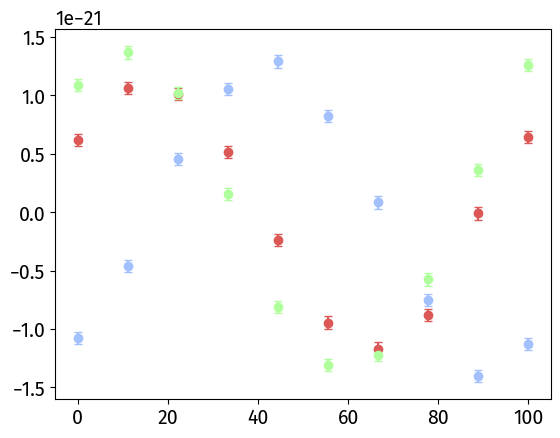

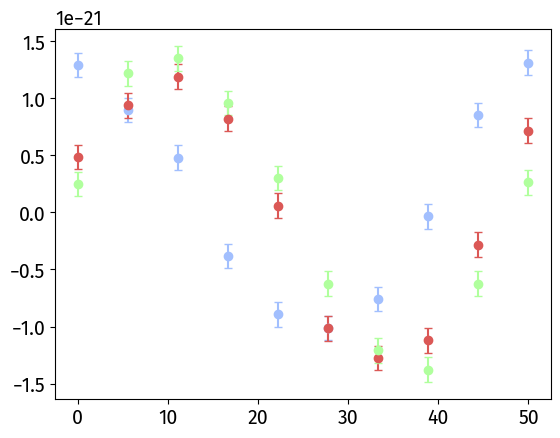

In [26]:
fits,fits2,T_1,T_2,S,S2 = dual_band_network_response(positions, arms, f_gw1,f_gw2, N_cycles_1,N_cycles_2, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp)


In [31]:
antenna_response_amp,antenna_response_amp_err,antenna_response_phase,antenna_response_phase_err,time_delay,time_delay_err  = dual_band_network_response_analyzer(fits,fits2) 

In [32]:
amp_response,phase_response = network_antenna_response(positions, arms, A_plus, A_cross, theta_sky, phi_sky,psi)
tau = tau_delay(positions, arms, A_plus, A_cross, theta_sky, phi_sky)


In [36]:
time_delay

array([ 0.        , 45.77729546, 52.77261775])

In [34]:
tau-tau[0]

array([ 0.        , 40.94488619, 51.24636375])

In [42]:
time_delay_err

array([2.541047  , 1.23204139, 1.16256412])

In [37]:
antenna_response_amp

array([1.        , 0.88506817, 1.07263327])

In [39]:
amp_response/amp_response[0]

array([1.        , 0.92976428, 1.07291045])

In [43]:
antenna_response_amp_err

array([0.01804101, 0.01900426, 0.0183295 ])

In [40]:
antenna_response_phase

array([-0.        , -1.82684031, -1.03222209])

In [41]:
phase_response-phase_response[0]

array([ 0.        , -2.10569756, -1.08254524])

In [44]:
antenna_response_phase_err

array([0.04228323, 0.04079532, 0.04015526])